# Laboratorio 2 - Visión por Computadora

- Diego Estuardo Lemus López - 21469
- José Pablo Kiesling Lange - 21581
- Herber Sebastián Silva Muñoz - 21764

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv

from scipy import ndimage as ndi

import skimage as ski
from skimage.filters import threshold_niblack
from skimage import morphology as mo
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

## 2. Consideramos de nuevo la imagen rice.jpg. Hacer lo siguiente

In [2]:
image_path = 'assets/rice.jpg'
image = plt.imread(image_path)
image_original = image

In [3]:
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

### a) Binarizar la imagen mediante el método de Otsu, o usando algún otro método no local

#### Segmentación binaria

In [4]:
threshold = threshold_niblack(image, window_size=51, k=-0.48)
image = image > threshold

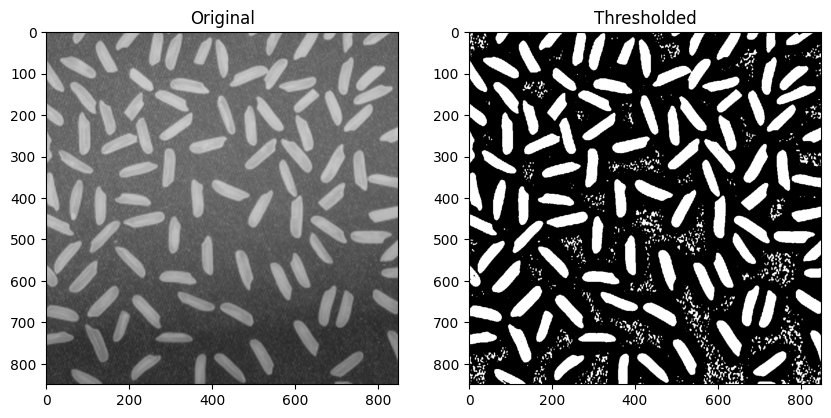

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(image, cmap='gray')
plt.title("Thresholded")
plt.show()

### b) Aplicar operaciones morfológicas adecuadas para limpiar el ruido de la binarización. Explicar por qué está eligiendo estas transformaciones morfológicas.

In [6]:
disk = mo.disk(5)
image = mo.binary_opening(image, disk)

In [7]:
disk = mo.disk(1)
image = mo.binary_erosion(image, disk)

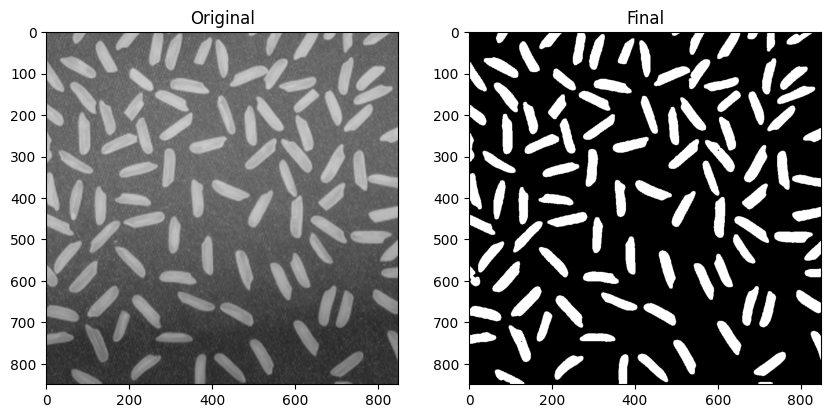

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(image, cmap='gray')
plt.title("Final")
plt.show()

### c) Aplicar un algoritmo de componentes conexas sobre la binarización y contar cuántos granos de arroz hay en la imagen 

In [9]:
C, M = mo.label(image, background=0, return_num=True, connectivity=2)

In [10]:
print("Number of grains:", M)

Number of grains: 100


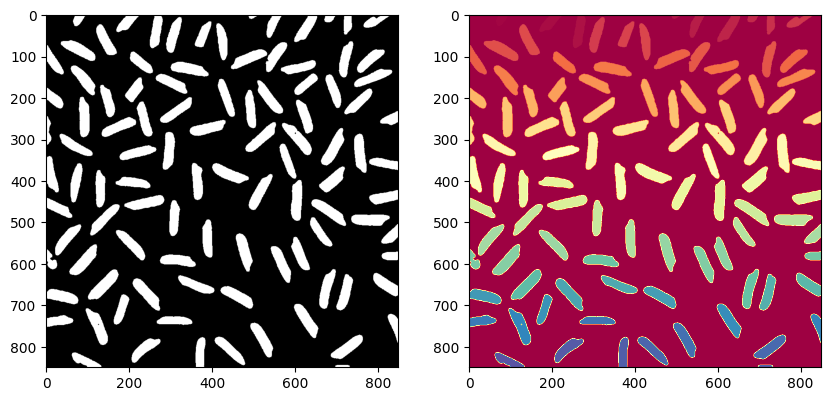

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(C, plt.cm.Spectral)
plt.show()

## 6. Para la imagen wheat.png, hacer lo siguiente 

### a) Segmentar la imagen de forma que se identifique de forma separada cada grano de trigo mediante el método de Watershed. 

#### Threshold con Niblack

In [12]:
image_path = 'assets/wheat.png'
image = plt.imread(image_path)
image_original = image

In [13]:
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

In [14]:
threshold = threshold_niblack(image, window_size=351, k=0.13)
binary = image > threshold
binary = (binary * 255).astype(np.uint8)

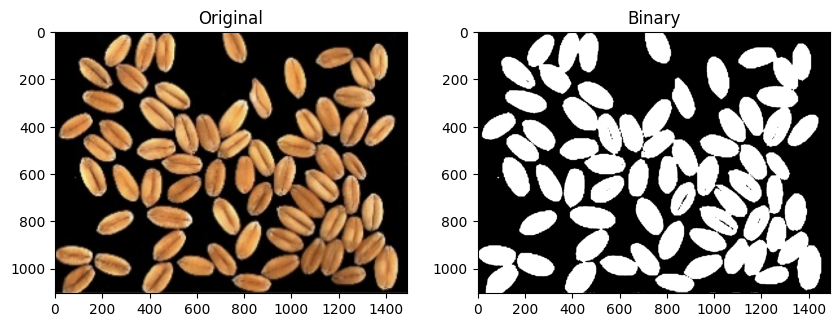

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(binary, cmap='gray')
plt.title("Binary")
plt.show()

#### Operaciones morfológicas

In [16]:
kernel = np.ones((3, 3), np.uint8)
sure_bg = cv.dilate(binary, kernel, iterations=3)

#### Watershed

In [17]:
distance = cv.distanceTransform(binary, cv.DIST_L2, 5)
_, sure_fg = cv.threshold(distance, 0.4 * distance.max(), 255, 0)

In [18]:
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

In [19]:
_, markers = cv.connectedComponents(sure_fg)
markers += 1 
markers[unknown == 255] = 0 

In [20]:
image_color = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

In [21]:
cv.watershed(image_color, markers)

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

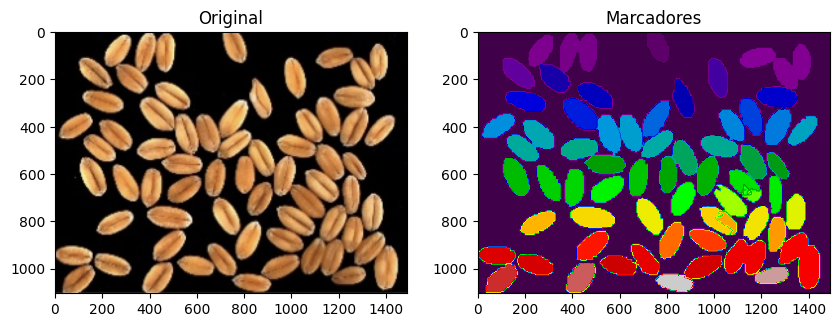

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(markers, cmap='nipy_spectral')
plt.title("Marcadores")
plt.show()

### b) Construir el mapa de clases, pintando de color negro el fondo, y cada grano con un color distinto. 

In [23]:
unique_labels = np.unique(markers)
class_map = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)

In [24]:
for label in unique_labels:
    if label == 1: 
        class_map[markers == label] = [0, 0, 0]
    elif label > 1:
        color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
        class_map[markers == label] = color

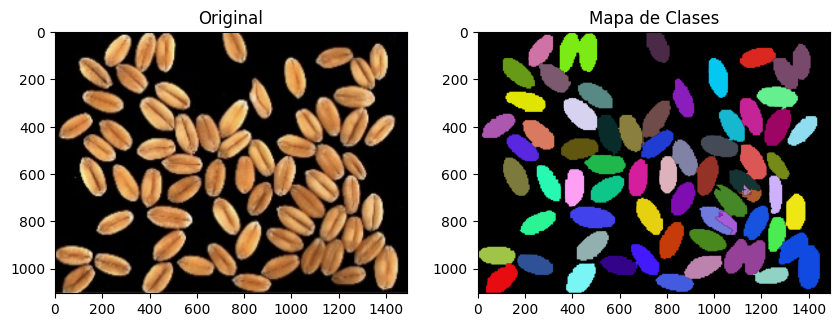

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(class_map)
plt.title("Mapa de Clases")
plt.show()

### c) Combinar la imagen original con una versión pálida del mapa de colores (modifique el canal α del mapa de clases y súmelo con la imagen original), para mostrar los colores obtenidos en el mapa de clases sobre cada grano. 

In [26]:
image_original_color = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
alpha = 0.5 
overlay = cv.addWeighted(image_original_color, 1 - alpha, class_map, alpha, 0)

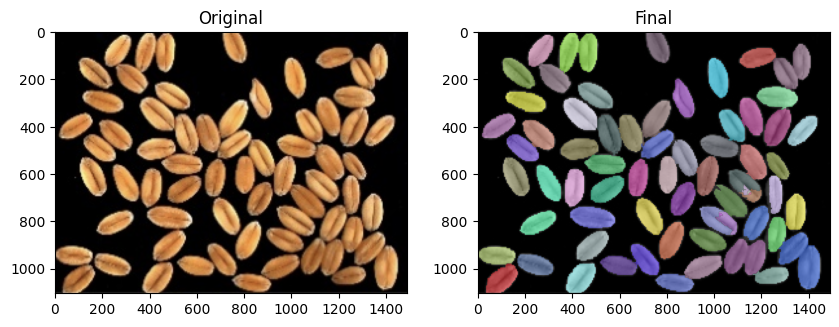

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Final")
plt.show()